<a href="https://colab.research.google.com/github/zzvcgmv/FHS/blob/main/FHS_MLClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#FHS_link = 'https://drive.google.com/file/d/1LTC4DR34YKCTMeW0H72hd8qo-dubcO6C/view?usp=sharing'
idFHS = "1LTC4DR34YKCTMeW0H72hd8qo-dubcO6C"
file = drive.CreateFile({'id':idFHS})
file.GetContentFile('framingham.csv')

**1. Load the Dataset and Import Packages**

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
sns.set()
sns.set_style("whitegrid")

In [50]:
df = pd.read_csv('framingham.csv')
df.head()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [51]:
# Convert columns to the correct data type
df['gender'] = df['gender'].astype('category')
df['education'] = df['education'].astype('category')
df['currentSmoker'] = df['currentSmoker'].astype('category')
df['BPMeds'] = df['BPMeds'].astype('category')
df['prevalentStroke'] = df['prevalentStroke'].astype('category')
df['prevalentHyp'] = df['prevalentHyp'].astype('category')
df['diabetes'] = df['diabetes'].astype('category')
df['TenYearCHD'] = df['TenYearCHD'].astype('category')

In [52]:
# Summary Statistics
## Continuous Variables
df.describe()
## Categorical Variable Distribution
categorical_columns = ["gender", "education", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]
categorical_summary = []
for col in categorical_columns:
    counts = df[col].value_counts(dropna=False)
    percentages = df[col].value_counts(normalize=True, dropna=False) * 100

    summary_df = pd.DataFrame({
        "Category": counts.index.fillna("Missing"),
        "Count": counts.values,
        "Percentage": percentages.values
    })

    summary_df["Cumulative Percentage"] = summary_df["Percentage"].cumsum()

    summary_df["Variable"] = col
    categorical_summary.append(summary_df)

categorical_summary_df = pd.concat(categorical_summary)
print(categorical_summary_df)

  Category  Count  Percentage  Cumulative Percentage         Variable
0        0   2420   57.075472              57.075472           gender
1        1   1820   42.924528             100.000000           gender
0      1.0   1720   40.566038              40.566038        education
1      2.0   1253   29.551887              70.117925        education
2      3.0    689   16.250000              86.367925        education
3      4.0    473   11.155660              97.523585        education
4  Missing    105    2.476415             100.000000        education
0        0   2145   50.589623              50.589623    currentSmoker
1        1   2095   49.410377             100.000000    currentSmoker
0      0.0   4063   95.825472              95.825472           BPMeds
1      1.0    124    2.924528              98.750000           BPMeds
2  Missing     53    1.250000             100.000000           BPMeds
0        0   4215   99.410377              99.410377  prevalentStroke
1        1     25   

**2. Data Clean**

1.   Missing Values Check and Imputation
2.   Data Preprocessing



In [53]:
df.isnull()
missingValues = df.isnull().sum()
missingValues

,0
gender,0
age,0
education,105
currentSmoker,0
cigsPerDay,29
BPMeds,53
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,50


In [54]:
# Impute missing values in 'education' with the mode (most frequent value)
impute_mode = ['education', 'BPMeds']
impute_median = ['cigsPerDay', 'totChol', 'BMI', 'heartRate', 'glucose']

for col in impute_mode:
    df[col].fillna(df[col].mode()[0], inplace=True)

for col in impute_median:
    df[col].fillna(df[col].median(), inplace=True)

df.isnull().sum()

,0
gender,0
age,0
education,0
currentSmoker,0
cigsPerDay,0
BPMeds,0
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,0


In [55]:
# Preprocessing
df.duplicated().sum()
framingham = df.drop_duplicates()
framingham.shape

(4240, 16)

In [56]:
df.head()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [57]:
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from collections import Counter
import statsmodels.api as sm

**Machine Learning**

    Data Clean and Processing for Modeling

1.   Logistic Regression Model
2.   KNeighbour Classifier
3.   DecisionTree Classifier
4.   RandomForest Classifier



In [58]:
# Modeling Target Variable: TenYearCHD
# Convert categorical columns to object dtype before get_dummies
df[categorical_columns] = df[categorical_columns].astype('object')
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Fill any potential NaNs introduced by get_dummies before converting to int
df_encoded = df_encoded.fillna(0).astype(int)
df_encoded.head()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,gender_1,education_2.0,education_3.0,education_4.0,currentSmoker_1,BPMeds_1.0,prevalentStroke_1,prevalentHyp_1,diabetes_1
0,39,0,195,106,70,26,80,77,0,1,0,0,1,0,0,0,0,0
1,46,0,250,121,81,28,95,76,0,0,1,0,0,0,0,0,0,0
2,48,20,245,127,80,25,75,70,0,1,0,0,0,1,0,0,0,0
3,61,30,225,150,95,28,65,103,1,0,0,1,0,1,0,0,1,0
4,46,23,285,130,84,23,85,85,0,0,0,1,0,1,0,0,0,0


In [59]:
x = df_encoded.drop(columns=['TenYearCHD'])
y = df_encoded['TenYearCHD']

,count
TenYearCHD,
0,3596
1,644


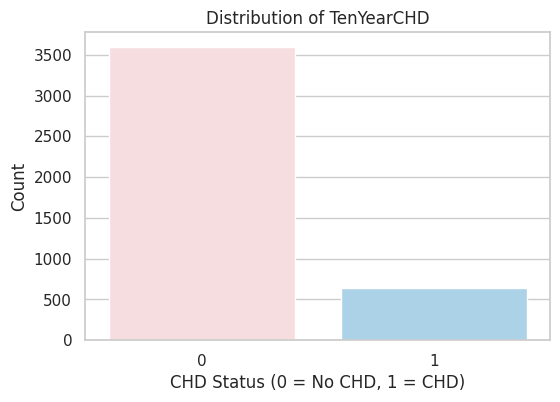

In [60]:
# Imbalance entire Outcome: TenYearCHD
chdCount = y.value_counts()
colors1 = ["#FADADD", "#A2D5F2"]
plt.figure(figsize=(6,4))
sns.barplot(x=chdCount.index, y=chdCount.values, palette=colors1)
plt.title("Distribution of TenYearCHD")
plt.xlabel("CHD Status (0 = No CHD, 1 = CHD)")
plt.ylabel("Count")
plt.xticks(rotation = 0)
chdCount
## The dataset of outcome is seriously imbalanced, apply Oversampling

In [61]:
# Split the dataset into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

Apply **Oversampling** to balance the dataset

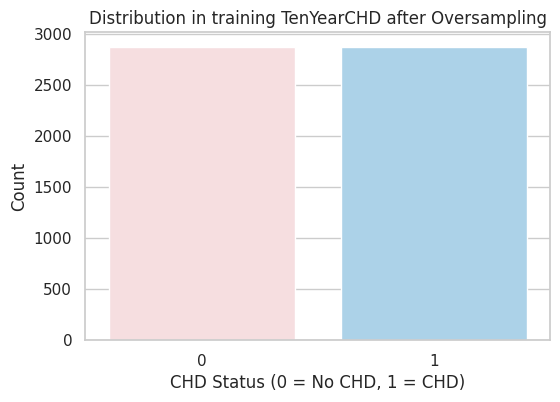

In [62]:
# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

plt.figure(figsize=(6,4))
sns.barplot(x=y_train_resampled.value_counts().index, y=y_train_resampled.value_counts().values, palette=colors1)
plt.title("Distribution in training TenYearCHD after Oversampling")
plt.xlabel("CHD Status (0 = No CHD, 1 = CHD)")
plt.ylabel("Count")
plt.show()
## Ensure the model is trained on a balanced dataset.

In [63]:
# RFE with RandomForest
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=7)
rfeModel = rfe.fit(x_train_resampled, y_train_resampled)
rfeModel
rfeModel.ranking_
rfeModel.feature_names_in_

array(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI',
       'heartRate', 'glucose', 'gender_1', 'education_2.0',
       'education_3.0', 'education_4.0', 'currentSmoker_1', 'BPMeds_1.0',
       'prevalentStroke_1', 'prevalentHyp_1', 'diabetes_1'], dtype=object)

In [64]:
# Feature Ranking in a DataFrame
rank = pd.DataFrame({'Features': rfeModel.feature_names_in_,'Ranking': rfeModel.ranking_})
rank[rank['Ranking'] == 1]['Features'].values

array(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'heartRate',
       'glucose'], dtype=object)

In [65]:
features=[]
for i in rank[rank['Ranking']==1]['Features'].values:
    features.append(i)
features

['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'heartRate', 'glucose']

In [66]:
x_train_rfe = x_train_resampled[features]
x_test_rfe = x_test[features]

***LogisticRegressionClassifier()***

In [67]:
# Baseline Model
## Initialize Logistic Regression Classifier
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_rfe)
x_test_scaled = scaler.transform(x_test_rfe)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train_rfe.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test_rfe.columns)
logisticModel = LogisticRegression(max_iter = 1000, class_weight="balanced", random_state=42)
logisticModel.fit(x_train_scaled, y_train_resampled)

y_pred_train = logisticModel.predict(x_train_scaled)
y_pred_test = logisticModel.predict(x_test_scaled)

print("The train accuracy score is: ",accuracy_score(y_train_resampled,y_pred_train))
print("The test accuracy score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train precision score is: ",precision_score(y_train_resampled,y_pred_train))
print("The test precision score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train recall score is: ",recall_score(y_train_resampled,y_pred_train))
print("The test recall score is: ",recall_score(y_test,y_pred_test))
print("-"*50)
print("The train f1-score score is: ",f1_score(y_train_resampled,y_pred_train))
print("The test f1-score score is: ",f1_score(y_test,y_pred_test))

The train accuracy score is:  0.6675374433995124
The test accuracy score is:  0.6415094339622641
--------------------------------------------------
The train precision score is:  0.6626098715348209
The test precision score is:  0.6415094339622641
--------------------------------------------------
The train recall score is:  0.6826889585510275
The test recall score is:  0.6016260162601627
--------------------------------------------------
The train f1-score score is:  0.6724995711099674
The test f1-score score is:  0.3274336283185841


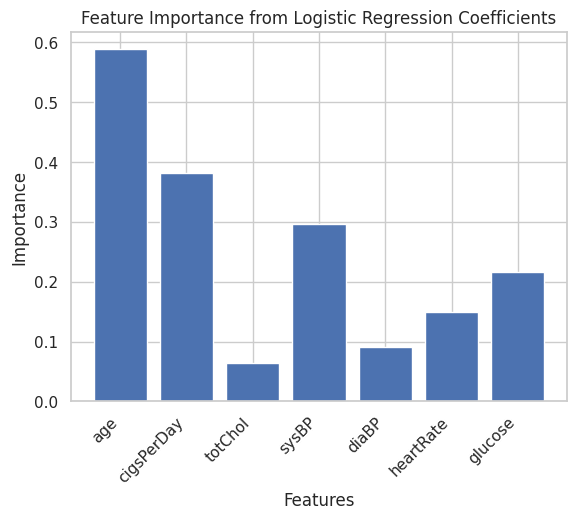

In [68]:
# Compute permutation importance
logistic_perm_importance = permutation_importance(logisticModel, x_test_scaled, y_test, n_repeats=10, random_state=42)

logistic_feature_importance = pd.DataFrame({
    "Feature": x_train_scaled.columns,
    "Importance": logistic_perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)
logistic_feature_importance

# Access the coefficients of the fitted logistic regression model
logistic_importance = np.abs(logisticModel.coef_[0])

# Plot feature importance based on coefficients
plt.bar(x_train_scaled.columns, logistic_importance)
plt.title("Feature Importance from Logistic Regression Coefficients")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.show()

In [69]:
# Optimization
## Apply L1 Regularization (LASSO) to Remove Correlated Features
lassoModel = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, class_weight="balanced", random_state=42)
lassoModel.fit(x_train_resampled, y_train_resampled)

lassoFeatures = x_train_resampled.columns[lassoModel.coef_[0] != 0]
lassoFeatures = lassoFeatures[:7] # Select top 7 features as RFE
lassoFeatures
# Index(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', dtype='object')
# Compared the features selected by RFE vs. LASSO, add 'BMI' and remove 'glucose'

Index(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate'], dtype='object')

In [70]:
x_train_lasso = x_train_resampled[lassoFeatures]
x_test_lasso = x_test[lassoFeatures]

lassoModel.fit(x_train_lasso, y_train_resampled)
y_pred_lasso_train = lassoModel.predict(x_train_lasso)
y_pred_lasso_test = lassoModel.predict(x_test_lasso)

print("The train accuracy score is: ",accuracy_score(y_train_resampled,y_pred_lasso_train))
print("The test accuracy score is: ",accuracy_score(y_test,y_pred_lasso_test))
print("-"*50)
print("The train precision score is: ",precision_score(y_train_resampled,y_pred_lasso_train))
print("The test precision score is: ",accuracy_score(y_test,y_pred_lasso_test))
print("-"*50)
print("The train recall score is: ",recall_score(y_train_resampled,y_pred_lasso_train))
print("The test recall score is: ",recall_score(y_test,y_pred_lasso_test))
print("-"*50)
print("The train f1-score score is: ",f1_score(y_train_resampled,y_pred_lasso_train))
print("The test f1-score score is: ",f1_score(y_test,y_pred_lasso_test))
# Worse performance, give it up

The train accuracy score is:  0.6607453848833159
The test accuracy score is:  0.6356132075471698
--------------------------------------------------
The train precision score is:  0.6567062818336163
The test precision score is:  0.6356132075471698
--------------------------------------------------
The train recall score is:  0.6736328805294323
The test recall score is:  0.6097560975609756
--------------------------------------------------
The train f1-score score is:  0.6650618982118295
The test f1-score score is:  0.32679738562091504


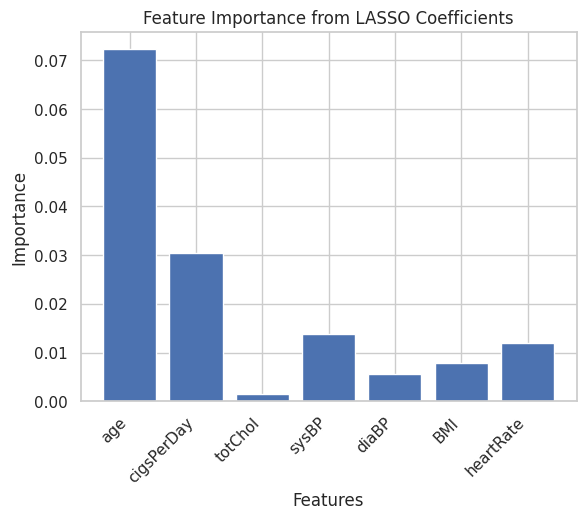

In [71]:
# Compute LASSO permutation importance
lasso_perm_importance = permutation_importance(lassoModel, x_test_lasso, y_test, n_repeats=10, random_state=42)

lasso_feature_importance = pd.DataFrame({
    "Feature": x_train_lasso.columns,
    "Importance": lasso_perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)
lasso_feature_importance

lasso_importance = np.abs(lassoModel.coef_[0])
plt.bar(x_train_lasso.columns, lasso_importance)
plt.title("Feature Importance from LASSO Coefficients")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.show()

***KNeighboursClassifier()***

In [72]:
# Baseline Model
## Initialize KNN Classifier
knn = KNeighborsClassifier() # Default: n_neighbour = 5, metric = 'minkowski'
knnModel = knn.fit(x_train_scaled, y_train_resampled)
knnModel
y_pred_train = knnModel.predict(x_train_scaled)
y_pred_test = knnModel.predict(x_test_scaled)

print("The train accuracy score is: ",accuracy_score(y_train_resampled,y_pred_train))
print("The test accuracy score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train precision score is: ",precision_score(y_train_resampled,y_pred_train))
print("The test precision score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train recall score is: ",recall_score(y_train_resampled,y_pred_train))
print("The test recall score is: ",recall_score(y_test,y_pred_test))
print("-"*50)
print("The train f1-score score is: ",f1_score(y_train_resampled,y_pred_train))
print("The test f1-score score is: ",f1_score(y_test,y_pred_test))
print("-"*50)

The train accuracy score is:  0.874085684430512
The test accuracy score is:  0.6438679245283019
--------------------------------------------------
The train precision score is:  0.8075601374570447
The test precision score is:  0.6438679245283019
--------------------------------------------------
The train recall score is:  0.9822361546499477
The test recall score is:  0.4959349593495935
--------------------------------------------------
The train f1-score score is:  0.8863743517208864
The test f1-score score is:  0.28773584905660377
--------------------------------------------------


Optimzed Model:

Apply **Euclidean distance with neighbor number = 5** *(high-dimension hyperparameter settings)* and **Mahanttan distance with neighbor number = 3** *(configurations after GridSearchCV optimization over key hyperparameters)* to the same scaled data to get the accompanying plot for further Classifiers due to the top performaces from cross-validation to balance train/test metrices, along with the evaluation for overfitting and generalization.

In [73]:
params=[{'n_neighbors': [3, 5, 7, 9], 'metric': ['euclidean', 'manhattan', 'minkowski']}]
grd=GridSearchCV(estimator = knn,param_grid=params,cv = 3)
grd_model=grd.fit(x_train_scaled,y_train_resampled)
grd_model.best_params_

{'metric': 'manhattan', 'n_neighbors': 3}

In [74]:
knn1 = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 5)
knn1Model = knn1.fit(x_train_scaled, y_train_resampled)
y_pred_train = knn1Model.predict(x_train_scaled)
y_pred_test = knn1Model.predict(x_test_scaled)

print("The train accuracy score is: ",accuracy_score(y_train_resampled,y_pred_train))
print("The test accuracy score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train precision score is: ",precision_score(y_train_resampled,y_pred_train))
print("The test precision score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train recall score is: ",recall_score(y_train_resampled,y_pred_train))
print("The test recall score is: ",recall_score(y_test,y_pred_test))
print("-"*50)
print("The train f1-score score is: ",f1_score(y_train_resampled,y_pred_train))
print("The test f1-score score is: ",f1_score(y_test,y_pred_test))

The train accuracy score is:  0.874085684430512
The test accuracy score is:  0.6438679245283019
--------------------------------------------------
The train precision score is:  0.8075601374570447
The test precision score is:  0.6438679245283019
--------------------------------------------------
The train recall score is:  0.9822361546499477
The test recall score is:  0.4959349593495935
--------------------------------------------------
The train f1-score score is:  0.8863743517208864
The test f1-score score is:  0.28773584905660377


In [75]:
knn2 = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3)
knn2Model = knn2.fit(x_train_scaled, y_train_resampled)
y_pred_train = knn2Model.predict(x_train_scaled)
y_pred_test = knn2Model.predict(x_test_scaled)

print("The train accuracy score is: ",accuracy_score(y_train_resampled,y_pred_train))
print("The test accuracy score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train precision score is: ",precision_score(y_train_resampled,y_pred_train))
print("The test precision score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train recall score is: ",recall_score(y_train_resampled,y_pred_train))
print("The test recall score is: ",recall_score(y_test,y_pred_test))
print("-"*50)
print("The train f1-score score is: ",f1_score(y_train_resampled,y_pred_train))
print("The test f1-score score is: ",f1_score(y_test,y_pred_test))

The train accuracy score is:  0.9146638801811215
The test accuracy score is:  0.6863207547169812
--------------------------------------------------
The train precision score is:  0.8589086523967441
The test precision score is:  0.6863207547169812
--------------------------------------------------
The train recall score is:  0.9923371647509579
The test recall score is:  0.43902439024390244
--------------------------------------------------
The train f1-score score is:  0.920814479638009
The test f1-score score is:  0.2887700534759358




*   KNN Model slightly outperformed or matched KNN Model with Eucild distance (n_neighbor = 5) in CV grid search with {'metric': 'manhattan', 'n_neighbors': 3} being the best param set.

*   The Manhattan metric often performs better in high-dimensional or sparse data, which matches your scaled 7-feature setup.

*   A smaller k = 3 gives more flexible decision boundaries, which can be helpful when classifying minority-class CHD cases post-SMOTE.

**However, its test performance sharply deteriorated**

| Metric   | Train | Test  |
| -------- | ----- | ----- |
| Recall   | 98.3% | 49.6% |
| F1-Score | 88.6% | 28.7% |


1.   **Severe Overfitting**: KNN memorized the training set especially after SMOTE, but failed to generalize to unseen test data.
2.   **Poor test F1-score** undermines reliability in identifying actual CHD cases.
3.   **Generalization gap** remained large.

***Conclusion***:

KNN was excluded due to instability and poor generalization, especially for minority class detection, making it unreliable for CHD screening in a public health context.


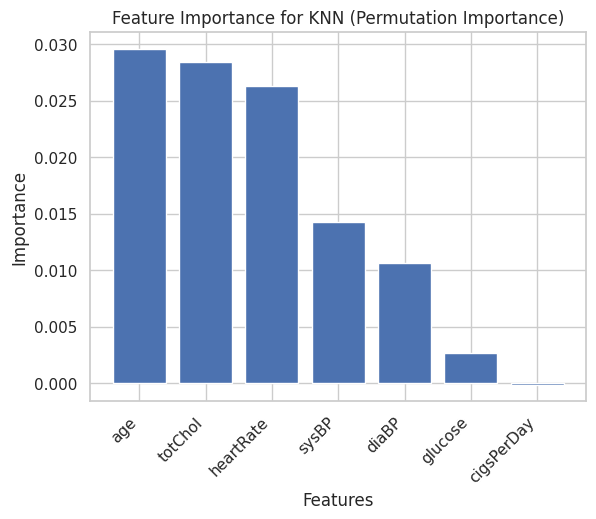

In [76]:
knn_perm_importance = permutation_importance(knn2Model, x_test_scaled, y_test, n_repeats=10, random_state=42)

# Create a DataFrame to store feature importance
knn_feature_importance = pd.DataFrame({
    "Feature": x_train_scaled.columns,
    "Importance": knn_perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.bar(knn_feature_importance["Feature"], knn_feature_importance["Importance"])
plt.title("Feature Importance for KNN (Permutation Importance)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

***DecisionTreeClassifier()***

In [77]:
dt = DecisionTreeClassifier()
dtModel = dt.fit(x_train_rfe, y_train_resampled)
dtModel

y_pred_train = dtModel.predict(x_train_rfe)
y_pred_test = dtModel.predict(x_test_rfe)

print("The train accuracy score is: ",accuracy_score(y_train_resampled,y_pred_train))
print("The test accuracy score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train precision score is: ",precision_score(y_train_resampled,y_pred_train))
print("The test precision score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train recall score is: ",recall_score(y_train_resampled,y_pred_train))
print("The test recall score is: ",recall_score(y_test,y_pred_test))
print("-"*50)
print("The train f1-score score is: ",f1_score(y_train_resampled,y_pred_train))
print("The test f1-score score is: ",f1_score(y_test,y_pred_test))
# Overfitting!

The train accuracy score is:  1.0
The test accuracy score is:  0.7110849056603774
--------------------------------------------------
The train precision score is:  1.0
The test precision score is:  0.7110849056603774
--------------------------------------------------
The train recall score is:  1.0
The test recall score is:  0.2601626016260163
--------------------------------------------------
The train f1-score score is:  1.0
The test f1-score score is:  0.20711974110032363


In [78]:
params=[{'criterion':['gini','entropy'],'max_depth':range(4,11),'min_samples_split':range(2,10)}]
grd=GridSearchCV(estimator=dt,param_grid=params,cv=3)
grd_model=grd.fit(x_train_rfe,y_train_resampled)
grd_model.best_params_  # {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3}

In [79]:
dt=DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_split=2)
dtModel=dt.fit(x_train_rfe,y_train_resampled)
y_pred_train=dtModel.predict(x_train_rfe)
y_pred_test=dtModel.predict(x_test_rfe)

print("The train accuracy score is: ",accuracy_score(y_train_resampled,y_pred_train))
print("The test accuracy score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train precision score is: ",precision_score(y_train_resampled,y_pred_train))
print("The test precision score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train recall score is: ",recall_score(y_train_resampled,y_pred_train))
print("The test recall score is: ",recall_score(y_test,y_pred_test))
print("-"*50)
print("The train f1-score score is: ",f1_score(y_train_resampled,y_pred_train))
print("The test f1-score score is: ",f1_score(y_test,y_pred_test))

The train accuracy score is:  0.829153605015674
The test accuracy score is:  0.6415094339622641
--------------------------------------------------
The train precision score is:  0.8052325581395349
The test precision score is:  0.6415094339622641
--------------------------------------------------
The train recall score is:  0.8683385579937304
The test recall score is:  0.34146341463414637
--------------------------------------------------
The train f1-score score is:  0.8355957767722474
The test f1-score score is:  0.21649484536082475


**Tuned decision tree reduced overfitting** compared to its default version, but still underperformed:

| Metric   | Train | Test  |
| -------- | ----- | ----- |
| Recall   | 91.6% | 48.0% |
| F1-Score | 84.3% | 26.3% |


1.   **Test recall below 50%** is unacceptable for CHD detection.
  *   **Test recall shows how many people at real risk of CHD the model correctly identifies on new data**. 48.0%, meaning it missed more than half of the people who truly had CHD risk. This is unacceptable because it means many high-risk individuals would go undetected.


2.   Even with hyperparameter tuning (max_depth=10, min_samples_split=2), the **sensitivity remained low**.
3.   High variance suggests that the tree is sensitive to SMOTE-generated samples, possibly overfitting their patterns.

***Conclusion***:

Decision Tree was dropped due to low sensitivity and high variance, making it less suitable for a recall-prioritized classification goal.

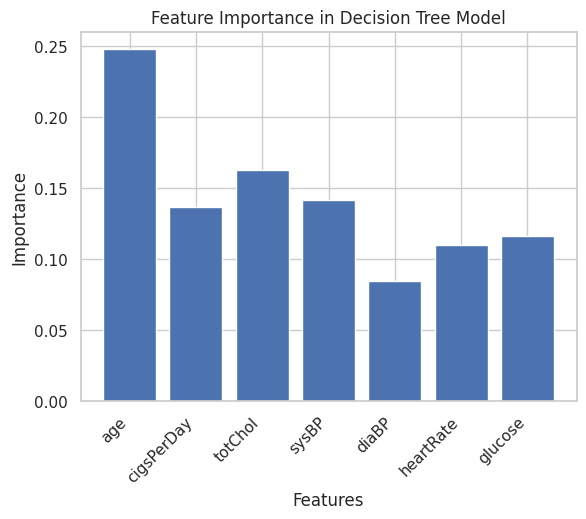

In [80]:
plt.bar(x_train_rfe.columns, dtModel.feature_importances_)
plt.title("Feature Importance in Decision Tree Model")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.show()

***RandomForestClassifier()***

In [81]:
rf = RandomForestClassifier()
rfModel = rf.fit(x_train_rfe, y_train_resampled)
rfModel
y_pred_train=rfModel.predict(x_train_rfe)
y_pred_test=rfModel.predict(x_test_rfe)

print("The train accuracy score is: ",accuracy_score(y_train_resampled,y_pred_train))
print("The test accuracy score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train precision score is: ",precision_score(y_train_resampled,y_pred_train))
print("The test precision score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train recall score is: ",recall_score(y_train_resampled,y_pred_train))
print("The test recall score is: ",recall_score(y_test,y_pred_test))
print("-"*50)
print("The train f1-score score is: ",f1_score(y_train_resampled,y_pred_train))
print("The test f1-score score is: ",f1_score(y_test,y_pred_test))
# Overfitting

The train accuracy score is:  1.0
The test accuracy score is:  0.7759433962264151
--------------------------------------------------
The train precision score is:  1.0
The test precision score is:  0.7759433962264151
--------------------------------------------------
The train recall score is:  1.0
The test recall score is:  0.21951219512195122
--------------------------------------------------
The train f1-score score is:  1.0
The test f1-score score is:  0.22131147540983606


In [82]:
params = [{'n_estimators': [100,150,200], 'max_depth':range(2,4),'max_features':["sqrt", "log2", None]}]
grd = GridSearchCV(estimator=rf, param_grid=params, cv=3)
grd_model = grd.fit(x_train_rfe, y_train_resampled)
print(grd_model.best_params_)

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}


In [83]:
# {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 100}
rf1 = RandomForestClassifier(max_depth=3, max_features='log2', n_estimators=100, random_state=42)
rf1Model = rf1.fit(x_train_rfe, y_train_resampled)
y_pred_train = rf1Model.predict(x_train_rfe)
y_pred_test = rf1Model.predict(x_test_rfe)

print("The train accuracy score is: ",accuracy_score(y_train_resampled,y_pred_train))
print("The test accuracy score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train precision score is: ",precision_score(y_train_resampled,y_pred_train))
print("The test precision score is: ",accuracy_score(y_test,y_pred_test))
print("-"*50)
print("The train recall score is: ",recall_score(y_train_resampled,y_pred_train))
print("The test recall score is: ",recall_score(y_test,y_pred_test))
print("-"*50)
print("The train f1-score score is: ",f1_score(y_train_resampled,y_pred_train))
print("The test f1-score score is: ",f1_score(y_test,y_pred_test))

The train accuracy score is:  0.6837338906304423
The test accuracy score is:  0.625
--------------------------------------------------
The train precision score is:  0.6714332141696457
The test precision score is:  0.625
--------------------------------------------------
The train recall score is:  0.7196098920236851
The test recall score is:  0.5853658536585366
--------------------------------------------------
The train f1-score score is:  0.6946872898453261
The test f1-score score is:  0.3116883116883117


Despite its **robustness**, Random Forest failed to outperform simpler models like LASSO:

| Metric   | Train | Test  |
| -------- | ----- | ----- |
| Recall   | 72.0% | 62.5% |
| F1-Score | 69.5% | 31.2% |



1.   **Test Recall is lower than LASSO (61.0%)**

  *   Recall reflects how many people with real CHD risk the model correctly finds. In this task, we use recall to measure the model’s ability to catch true CHD cases. A higher recall means the model finds more of the people who actually have risk.

2.   **Overfitting risk**: RF had perfect training scores initially (100%), and even after tuning (max_depth=3, max_features='log2'), it still kept **more features**, reducing interpretability.

3.  **Permutation importance** plots show a flatter gradient of feature contributions than LASSO, making clinical interpretation harder.

***Conclusion***:

Random Forest was excluded because it did not improve **recall**, **increased model complexity**, and **reduced interpretability**, despite tuning.

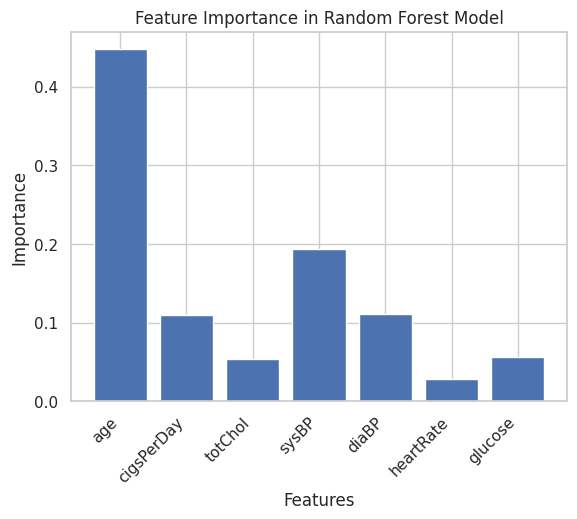

In [86]:
plt.bar(x_train_rfe.columns, rf1Model.feature_importances_)
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.show()

**Finally, LASSO was selected as the final model for predicting 10-year CHD risk** for the following clear reasons:

1.   **Higher Recall (61.0%)**
    
    Recall reflects how many true CHD-positive individuals the model correctly identifies. LASSO had the highest test recall among all models, meaning it caught **more real cases**, which is essential in public health screening to avoid missing high-risk individuals.
2.   **Most Balanced F1-Score (32.8%)**

    F1-score balances precision and recall. LASSO achieved the **best F1-score**, indicating it performed well not just in finding true cases, but also in avoiding too many false alarms.

3.   **Good Generalization**

    LASSO showed **small gaps between training and test performance**, unlike models like KNN or Decision Tree that overfit the training data and performed poorly on new data.

4.   **Automatic Feature Selection**

    LASSO kept only 7 important predictors (e.g., age, sysBP, cigsPerDay, BMI), *dropping weak or redundant variables like glucose*, which made the model simpler and easier to interpret in clinical settings.